In [25]:
import pandas as pd
from pprint import pprint
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('winequality-red.csv')

## Data preprocessing

In [4]:
def data_overview(df):
    print("Rows :  ", df.shape[0])
    print("Columns:  ", df.shape[1])
    print()
    print(df.dtypes)
    print()
    print('Missing rates : ')
    print(df.isnull().sum().sort_values(ascending=False)[:10]/df.shape[0])
    print()
    print('Unique values:')
    print(df.nunique().sort_values(ascending=False)[:10])
    print()
    print("List of columns:")
    pprint(df.columns.to_list())

In [5]:
data_overview(data)

Rows :   1599
Columns:   12

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Missing rates : 
quality                 0.0
alcohol                 0.0
sulphates               0.0
pH                      0.0
density                 0.0
total sulfur dioxide    0.0
free sulfur dioxide     0.0
chlorides               0.0
residual sugar          0.0
citric acid             0.0
dtype: float64

Unique values:
density                 436
chlorides               153
total sulfur dioxide    144
volatile acidity        143
sulphates                96
fixed acidity            96
residual sugar           91
pH                       89
citric acid         

In [6]:
X = data.drop('quality', axis=1)
y = data['quality']

## Feature selection

### Variance Threshold
+ numerical features

In [7]:
from sklearn.feature_selection import VarianceThreshold

In [9]:
vt = VarianceThreshold(threshold=3)
vt.fit(X)

VarianceThreshold(threshold=3)

In [10]:
# check variances for all num_cols
dict_variance = {}
for i, j in zip(X.columns.values, vt.variances_):
    dict_variance[i] = j
print(dict_variance)

{'fixed acidity': 3.0295205688671114, 'volatile acidity': 0.0320423261333205, 'citric acid': 0.03792375112494089, 'residual sugar': 1.9866539202698996, 'chlorides': 0.0022137573233114347, 'free sulfur dioxide': 109.34645676374501, 'total sulfur dioxide': 1081.42563558916, 'density': 3.5598017926307083e-06, 'pH': 0.023820274241131787, 'sulphates': 0.02871464701398349, 'alcohol': 1.1349371714889036}


In [12]:
# check filtered num_cols
ls = list()
for i,j in dict_variance.items():
    if j>=3:
        ls.append(i)
print(ls)

X_filtered = pd.DataFrame(vt.fit_transform(X),columns=ls)

['fixed acidity', 'free sulfur dioxide', 'total sulfur dioxide']


### Pearson Correlation

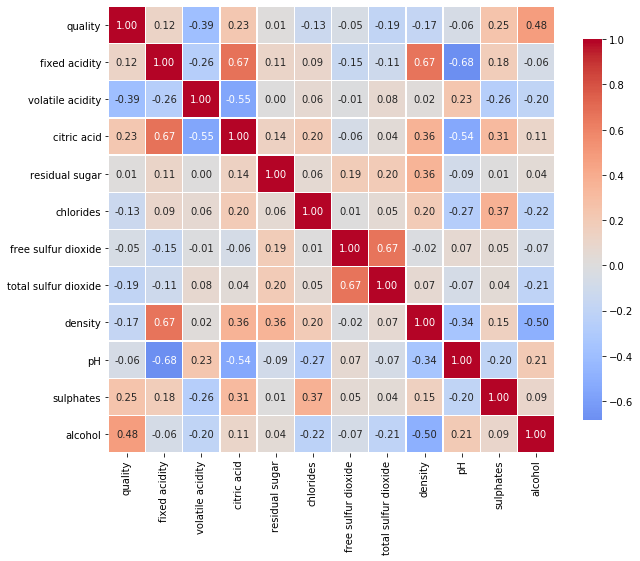

In [31]:
# method{‘pearson’, ‘kendall’, ‘spearman’}
correlations = pd.concat([y,X],axis=1).corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, cmap='coolwarm')
plt.show()    

+ choose features having high correlation with the target
    + eg: alcohol ...
+ delete the feature having high correlation with another feature
    + eg: critic acid & fixed acidity, drop critic acid
    + eg: density & fixed acidity, drop fixed acidity
    + eg: pH & fixed acidity,drop fixed acidity

In [34]:
correlations.abs().sum() # choose the bigger feature to drop

quality                 3.079591
fixed acidity           4.123043
volatile acidity        3.069612
citric acid             4.224007
residual sugar          2.208228
chlorides               2.654364
free sulfur dioxide     2.349599
total sulfur dioxide    2.714744
density                 3.865456
pH                      3.749081
sulphates               2.918300
alcohol                 3.183711
dtype: float64

### Mutual Information
+ categorical or numerical features
+ use mutual_info_classif for classification tasks
+ use mutual_info_regression for regression tasks
+ use an boolean array to index categorical features, send it to discrete_features
+ pro: can detect inter-variable relations

In [13]:
from sklearn.feature_selection import mutual_info_regression
mir = mutual_info_regression(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)

In [14]:
dict_feature = {}
for i, j in zip(X.columns.values, mir):
    dict_feature[i] = j
print(dict_feature)

{'fixed acidity': 0.06324617033190805, 'volatile acidity': 0.12363645345103169, 'citric acid': 0.08492584304728634, 'residual sugar': 0.04070095562739251, 'chlorides': 0.04536215069094318, 'free sulfur dioxide': 0.03208739570887875, 'total sulfur dioxide': 0.064939527290238, 'density': 0.0920983180690893, 'pH': 0.00039046256457719863, 'sulphates': 0.08204643171066994, 'alcohol': 0.18215543310076132}


In [15]:
# sort features
ls = sorted(dict_feature.items(), key = lambda item:item[1], reverse=True)
print(ls)

[('alcohol', 0.18215543310076132), ('volatile acidity', 0.12363645345103169), ('density', 0.0920983180690893), ('citric acid', 0.08492584304728634), ('sulphates', 0.08204643171066994), ('total sulfur dioxide', 0.064939527290238), ('fixed acidity', 0.06324617033190805), ('chlorides', 0.04536215069094318), ('residual sugar', 0.04070095562739251), ('free sulfur dioxide', 0.03208739570887875), ('pH', 0.00039046256457719863)]


In [16]:
# keep top 5 features
k = 5
ls_new = []
for i in range(k):
    ls_new.append(ls[i][0])

X_filtered = X[ls_new]

In [17]:
X_filtered.head()

,alcohol,volatile acidity,density,citric acid,sulphates
0,9.4,0.70,0.9978,0.00,0.56
1,9.8,0.88,0.9968,0.00,0.68
2,9.8,0.76,0.9970,0.04,0.65
3,9.8,0.28,0.9980,0.56,0.58
4,9.4,0.70,0.9978,0.00,0.56


### ANOVA F-test
+ numerical features
+ use f_classif for classification tasks
+ use f_regression for regression tasks
+ con: can only detect linear correlations

In [18]:
from sklearn.feature_selection import f_regression

In [20]:
(f_regression,pval)=f_regression(X,y)
dict_feature = {}
for i, j in zip(X.columns.values, f_regression):
    dict_feature[i] = j
print(dict_feature)

{'fixed acidity': 24.960037517470248, 'volatile acidity': 287.4444497061144, 'citric acid': 86.25772620091435, 'residual sugar': 0.301183699425499, 'chlorides': 26.98560839352944, 'free sulfur dioxide': 4.108502273747403, 'total sulfur dioxide': 56.65781755813237, 'density': 50.405223111723515, 'pH': 5.340462206974324, 'sulphates': 107.7404330156073, 'alcohol': 468.2670106420927}


In [21]:
# sort features
ls = sorted(dict_feature.items(), key = lambda item:item[1], reverse=True)
print(ls)

[('alcohol', 468.2670106420927), ('volatile acidity', 287.4444497061144), ('sulphates', 107.7404330156073), ('citric acid', 86.25772620091435), ('total sulfur dioxide', 56.65781755813237), ('density', 50.405223111723515), ('chlorides', 26.98560839352944), ('fixed acidity', 24.960037517470248), ('pH', 5.340462206974324), ('free sulfur dioxide', 4.108502273747403), ('residual sugar', 0.301183699425499)]


In [22]:
# keep top 5 features
k = 5
ls_new = []
for i in range(k):
    ls_new.append(ls[i][0])

In [23]:
X_filtered = X[ls_new]
X_filtered.head()

,alcohol,volatile acidity,sulphates,citric acid,total sulfur dioxide
0,9.4,0.70,0.56,0.00,34.0
1,9.8,0.88,0.68,0.00,67.0
2,9.8,0.76,0.65,0.04,54.0
3,9.8,0.28,0.58,0.56,60.0
4,9.4,0.70,0.56,0.00,34.0
